# Predict care givers’ depression

## Initial Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
seed = 257248

In [2]:
def evaluate(rf, train, valid, test, train_y, valid_y, return_pred=False, version=1, return_auc=False, plot_auc=False, save_path="", title="", return_acu=False):
    if version == 2:
        rf_train_y = rf.predict(train)
        rf_valid_y = rf.predict(valid)
        pred = rf.predict(test)
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}; Test: {np.sum(pred):>4d}")
        cm = confusion_matrix(train_y, rf_train_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Train AUROC: {roc_auc_score(train_y, rf_train_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        cm = confusion_matrix(valid_y, rf_valid_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Valid AUROC: {roc_auc_score(valid_y, rf_valid_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        print()
    elif version == 3:
        pred_train = rf.predict(train)
        pred_valid = rf.predict(valid)
        pred = rf.predict(test)
        print(f"Train RMSE: {mse(train_y, pred_train, squared=False):.4f}")
        print(f"Valid RMSE: {mse(valid_y, pred_valid, squared=False):.4f}")
    else:
        rf_train_y = rf.predict_proba(train)[:,1]
        rf_valid_y = rf.predict_proba(valid)[:,1]
        if test is not None:
            pred = rf.predict_proba(test)[:,1]
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}")
        auc_train = roc_auc_score(train_y, rf_train_y)
        auc_valid = roc_auc_score(valid_y, rf_valid_y)
        print(f"Train AUROC: {auc_train:.4f}")
        print(f"Valid AUROC: {auc_valid:.4f}")
        print()
    if plot_auc:
        try:
            fpr1, tpr1, thresholds1 = roc_curve(train_y, rf_train_y)
            fpr2, tpr2, thresholds2 = roc_curve(valid_y, rf_valid_y)
            plt.plot([0,1], 'k--')
            plt.plot(fpr1, tpr1, label= "Train")
            plt.plot(fpr2, tpr2, label= "Valid")
            plt.legend()
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            if title:
                plt.title(title)
            else:
                plt.title('AUROC Curve')
            if save_path:
                plt.savefig(save_path)
            plt.show()
            # plot_roc_curve(rf, train, train_y)
            # plot_roc_curve(rf, valid, valid_y)
        except:
            pass
    if test is None:
        if return_acu:
            return acr_train, acr_valid
        else:
            return
    if return_pred and return_auc and version == 1:
        return pred, auc_train, auc_valid
    elif return_pred and return_acu:
        return acr_train, acr_valid, pred
    elif return_pred and (not return_acu):
        return pred
    elif (not return_pred) and return_acu:
        return acr_train, acr_valid
    else:
        return

In [3]:
def preprocess(df_sub, df_adl):
    df = pd.concat([df_sub, df_adl], axis=1)
    return df

In [4]:
def std(train, valid, cols=[]):
    if not cols:
        cols = train.columns
    scaler = StandardScaler()
    train[cols] = scaler.fit_transform(train[cols])
    valid[cols] = scaler.transform(valid[cols])

## Load Data

In [5]:
# modify dataset values for better model training
data = pd.read_pickle("../data/data.pkl")
data["BB1"] = data["BB1"] - 1
data["G1eA"] = data["G1eA"].replace({0: 1, 1: 0})
data["G1fA"] = data["G1fA"].replace({-1: 4})
data["G1gA"] = data["G1gA"].replace({0: 1, 1: 0})
data["G1hA"] = data["G1hA"].replace({0: 1, 1: 0})
data["G1iA"] = data["G1iA"].replace({0: 1, 1: 0})
print(len(data))

25394


In [6]:
# split dataset based on "G1eA" value
data_no_helper = data[data["G1eA"] == 2]
data_has_helper = data[data["G1eA"] != 2]

# discard observations with some missing criteria
null_cols = ["G1gA", "G1hA", "G1iA"]
data_discard = data_has_helper[
    (data_has_helper[null_cols[0]] == -1)
    | (data_has_helper[null_cols[1]] == -1)
    | (data_has_helper[null_cols[2]] == -1)
]
data_has_helper = data_has_helper[~data_has_helper.index.isin(data_discard.index)]
data_has_helper_index = data_has_helper.index
data_no_helper_index = data_no_helper.index

print(f"{len(data_has_helper)} {len(data_no_helper)} {len(data_discard)}")

24672 707 15


- `sex`  
    - `0` represents **Male**
    - `1` represents **Female**  
- `live_with_client`
    - `0` represents **No**
    - `1` represents **Yes**
    - `2` represents **No such helper**  
- `relationship`
    - `0` represents **Child or child-in-law or grandchild**
    - `1` represents **Spouse** 
    - `2` represents **Other relatives**
    - `3` represents **Friend/neighbor**
    - `4` represents **Others (e.g. maid)**
- `advice`
    - `0` represents **No**
    - `1` represents **Yes**
- `iadl`
    - `0` represents **No**
    - `1` represents **Yes**
- `adl`
    - `0` represents **No**
    - `1` represents **Yes**

In [7]:
# modify column names
modify_column_names = {
    "BB1": "sex",
    "G1eA": "live_with_client",
    "G1fA": "relationship",
    "G1gA": "advice",
    "G1hA": "iadl",
    "G1iA": "adl",
}
data_has_helper.rename(columns=modify_column_names, inplace=True)
data_no_helper.rename(columns=modify_column_names, inplace=True)

In [8]:
# get general features that will be used despite the ADLs
df_sub = data_has_helper[["sex", "live_with_client", "relationship", "advice", "iadl", "adl", "age"]]
df_label = data_has_helper["G2c"]

# get the training and validation index
train_index = train_test_split(df_label, test_size=0.2, random_state=seed)[0].index.to_list()
valid_index = train_test_split(df_label, test_size=0.2, random_state=seed)[1].index.to_list()
train_label = df_label.loc[train_index]
valid_label = df_label.loc[valid_index]
df_sub_train = df_sub.loc[train_index, :]
df_sub_valid = df_sub.loc[valid_index, :]
df_sub_train = pd.get_dummies(df_sub_train, columns=["sex", "live_with_client", "relationship", "advice", "iadl", "adl"])
df_sub_valid = pd.get_dummies(df_sub_valid, columns=["sex", "live_with_client", "relationship", "advice", "iadl", "adl"])
scaler = StandardScaler()
df_sub_train['age'] = scaler.fit_transform(df_sub_train[['age']])
df_sub_valid['age'] = scaler.transform(df_sub_valid[['age']])

# get the raw ADLs
adl_cols = ['H2a', 'H2b', 'H2c', 'H2d', 'H2e', 'H2f', 'H2g', 'H2h', 'H2i', 'H2j']
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]


## Model Fitting

### Input Preparation

In [9]:
train_list = []
valid_list = []

# R1
std(df_adl_raw_train, df_adl_raw_valid)
raw_train = preprocess(df_sub_train, df_adl_raw_train)
raw_valid = preprocess(df_sub_valid, df_adl_raw_valid)
train_list.append(raw_train)
valid_list.append(raw_valid)

In [10]:
# R2
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]
df_adl_oh_train = pd.get_dummies(df_adl_raw_train, columns=adl_cols)
df_adl_oh_valid = pd.get_dummies(df_adl_raw_valid, columns=adl_cols)
train_r2 = preprocess(df_sub_train, df_adl_oh_train)
valid_r2 = preprocess(df_sub_valid, df_adl_oh_valid)
train_list.append(train_r2)
valid_list.append(valid_r2)

In [11]:
# FA1
fa1 = pd.DataFrame(np.load("../npy/data_adl_pcfa2_varimax.npy"), columns=["Factor1", "Factor2"])
adl_train = fa1.loc[train_index, :]
adl_valid = fa1.loc[valid_index, :]
std(adl_train, adl_valid)
train_fa1 = preprocess(df_sub_train, adl_train)
valid_fa1 = preprocess(df_sub_valid, adl_valid)
train_list.append(train_fa1)
valid_list.append(valid_fa1)

In [12]:
# FA2
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]
fa1 = pd.DataFrame(np.load("../npy/data_adl_mlfa2_varimax.npy"), columns=["Factor1", "Factor2"])
adl_train = fa1.loc[train_index, :]
adl_valid = fa1.loc[valid_index, :]
std(adl_train, adl_valid)
train_fa1 = preprocess(df_sub_train, adl_train)
valid_fa1 = preprocess(df_sub_valid, adl_valid)
train_list.append(train_fa1)
valid_list.append(valid_fa1)

In [13]:
# PCA1
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]
fa1 = pd.DataFrame(np.load("../npy/data_adl_pca2.npy"), columns=["PC1", "PC2"])
adl_train = fa1.loc[train_index, :]
adl_valid = fa1.loc[valid_index, :]
std(adl_train, adl_valid)
train_fa1 = preprocess(df_sub_train, adl_train)
valid_fa1 = preprocess(df_sub_valid, adl_valid)
train_list.append(train_fa1)
valid_list.append(valid_fa1)

In [14]:
# AE1
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]
fa1 = pd.DataFrame(np.load("../ae_codes/best_model_fcn1_5_2_adamw_0.0001_64_encoded.npy"), columns=["Bottleneck1", "Bottleneck2"])
adl_train = fa1.loc[train_index, :]
adl_valid = fa1.loc[valid_index, :]
std(adl_train, adl_valid)
train_fa1 = preprocess(df_sub_train, adl_train)
valid_fa1 = preprocess(df_sub_valid, adl_valid)
train_list.append(train_fa1)
valid_list.append(valid_fa1)

In [15]:
# AE2
df_adl_raw = data_has_helper[adl_cols]
df_adl_raw_train = df_adl_raw.loc[train_index, :]
df_adl_raw_valid = df_adl_raw.loc[valid_index, :]
fa1 = pd.DataFrame(np.load("../ae_codes/best_model_fcn2_20_3_3_adamw_0.0001_64_encoded.npy"), columns=["Bottleneck1", "Bottleneck2", "Bottleneck3"])
adl_train = fa1.loc[train_index, :]
adl_valid = fa1.loc[valid_index, :]
std(adl_train, adl_valid)
train_fa1 = preprocess(df_sub_train, adl_train)
valid_fa1 = preprocess(df_sub_valid, adl_valid)
train_list.append(train_fa1)
valid_list.append(valid_fa1)

In [16]:
model_names = ['R1', 'R2', 'FA1', 'FA2', 'PCA1', 'AE1', 'AE2']
print(len(train_list))

7


In [17]:
if not os.path.exists("../fig/prediction/"):
    os.makedirs("../fig/prediction/")

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
def LR(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = LogisticRegression(solver='lbfgs', max_iter=100, C=1, penalty="l2", multi_class="ovr", class_weight=None, random_state=seed)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

Model R1
Train Accuracy: 0.6258; Validation Accuracy: 0.6391
Train AUROC: 0.6338
Valid AUROC: 0.6384



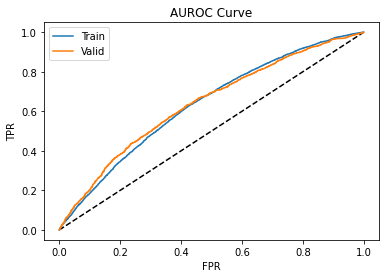

Model R2
Train Accuracy: 0.6370; Validation Accuracy: 0.6357
Train AUROC: 0.6531
Valid AUROC: 0.6440



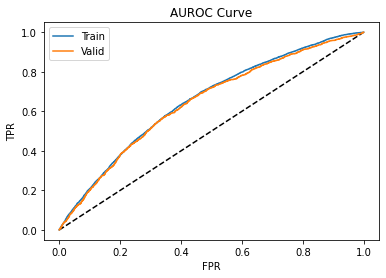

Model FA1
Train Accuracy: 0.6225; Validation Accuracy: 0.6387
Train AUROC: 0.6268
Valid AUROC: 0.6327



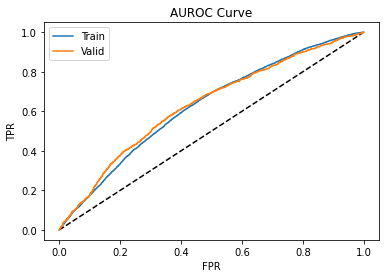

Model FA2
Train Accuracy: 0.6197; Validation Accuracy: 0.6332
Train AUROC: 0.6258
Valid AUROC: 0.6275



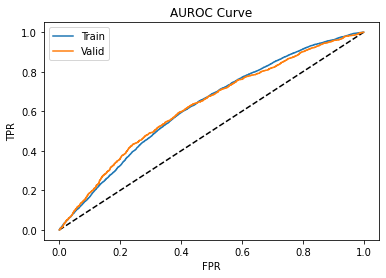

Model PCA1
Train Accuracy: 0.6227; Validation Accuracy: 0.6367
Train AUROC: 0.6274
Valid AUROC: 0.6340



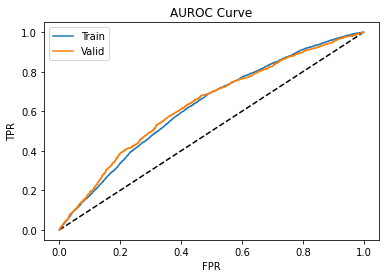

Model AE1
Train Accuracy: 0.6221; Validation Accuracy: 0.6367
Train AUROC: 0.6270
Valid AUROC: 0.6335



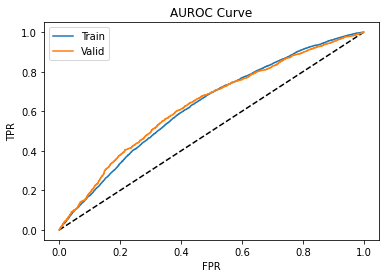

Model AE2
Train Accuracy: 0.6220; Validation Accuracy: 0.6395
Train AUROC: 0.6271
Valid AUROC: 0.6324



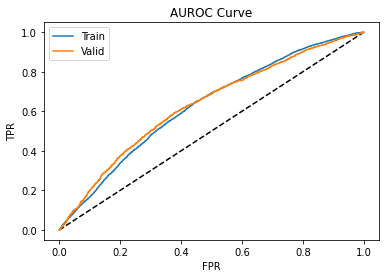

In [20]:
if not os.path.exists("../fig/prediction/LR/"):
    os.makedirs("../fig/prediction/LR/")
    
acr_lr = []
for i in range(len(train_list)):
    raw_train = train_list[i]
    raw_valid = valid_list[i]
    name = model_names[i]
    print(f"Model {name}")
    title = f"../fig/prediction/LR/{name}.png"
    acr_train, acr_valid = LR(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
    acr_lr.append((acr_train, acr_valid))

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
def RF(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=seed)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

Model R1
Train Accuracy: 0.6270; Validation Accuracy: 0.6302
Train AUROC: 0.6443
Valid AUROC: 0.6426



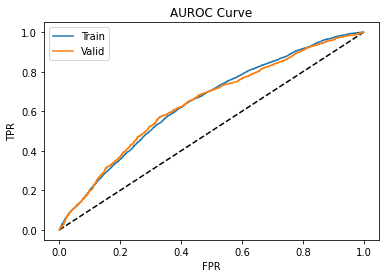

Model R2
Train Accuracy: 0.6163; Validation Accuracy: 0.6201
Train AUROC: 0.6488
Valid AUROC: 0.6444



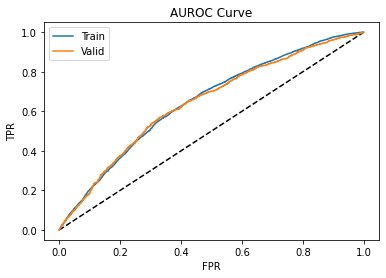

Model FA1
Train Accuracy: 0.6268; Validation Accuracy: 0.6314
Train AUROC: 0.6407
Valid AUROC: 0.6375



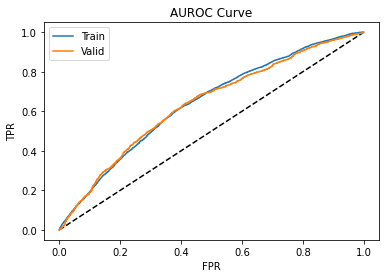

Model FA2
Train Accuracy: 0.6277; Validation Accuracy: 0.6304
Train AUROC: 0.6401
Valid AUROC: 0.6330



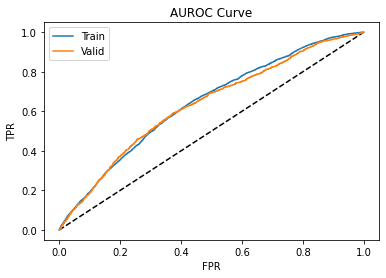

Model PCA1
Train Accuracy: 0.6271; Validation Accuracy: 0.6298
Train AUROC: 0.6410
Valid AUROC: 0.6383



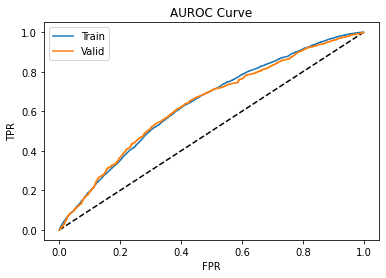

Model AE1
Train Accuracy: 0.6267; Validation Accuracy: 0.6310
Train AUROC: 0.6404
Valid AUROC: 0.6386



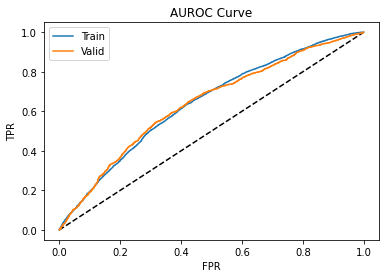

Model AE2
Train Accuracy: 0.6286; Validation Accuracy: 0.6263
Train AUROC: 0.6404
Valid AUROC: 0.6347



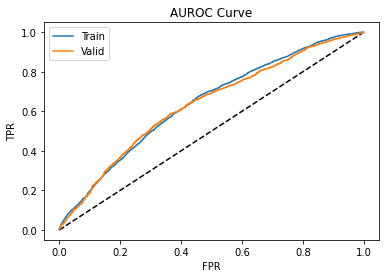

In [23]:
if not os.path.exists("../fig/prediction/RF/"):
    os.makedirs("../fig/prediction/RF/")
    
acr_rf = []
for i in range(len(train_list)):
    raw_train = train_list[i]
    raw_valid = valid_list[i]
    name = model_names[i]
    print(f"Model {name}")
    title = f"../fig/prediction/RF/{name}.png"
    acr_train, acr_valid = RF(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
    acr_rf.append((acr_train, acr_valid))

### Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

In [25]:
def GB(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = GradientBoostingClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=4, random_state=seed)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

Model R1
Train Accuracy: 0.6731; Validation Accuracy: 0.6632
Train AUROC: 0.7173
Valid AUROC: 0.6773



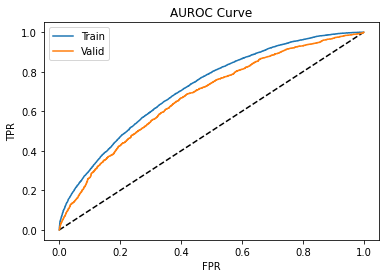

Model R2
Train Accuracy: 0.6758; Validation Accuracy: 0.6573
Train AUROC: 0.7216
Valid AUROC: 0.6780



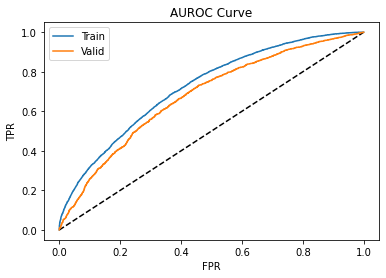

Model FA1
Train Accuracy: 0.6636; Validation Accuracy: 0.6498
Train AUROC: 0.7030
Valid AUROC: 0.6619



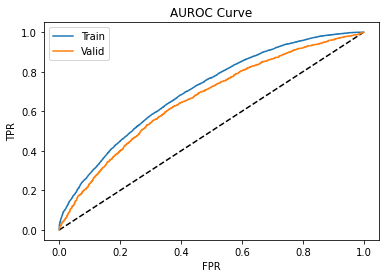

Model FA2
Train Accuracy: 0.6678; Validation Accuracy: 0.6488
Train AUROC: 0.7055
Valid AUROC: 0.6543



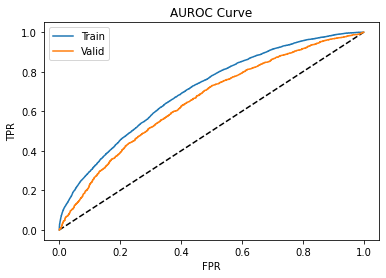

Model PCA1
Train Accuracy: 0.6663; Validation Accuracy: 0.6496
Train AUROC: 0.7021
Valid AUROC: 0.6588



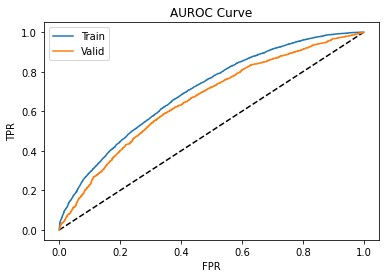

Model AE1
Train Accuracy: 0.6678; Validation Accuracy: 0.6452
Train AUROC: 0.7053
Valid AUROC: 0.6618



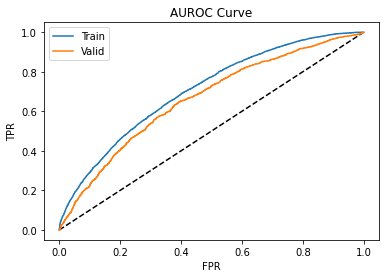

Model AE2
Train Accuracy: 0.6652; Validation Accuracy: 0.6466
Train AUROC: 0.7059
Valid AUROC: 0.6603



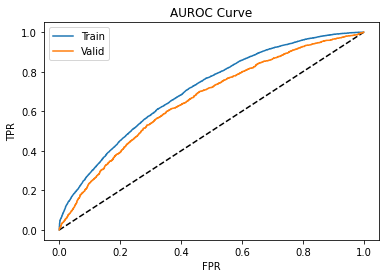

In [26]:
if not os.path.exists("../fig/prediction/GB/"):
    os.makedirs("../fig/prediction/GB/")
    
acr_gb = []
for i in range(len(train_list)):
    raw_train = train_list[i]
    raw_valid = valid_list[i]
    name = model_names[i]
    print(f"Model {name}")
    title = f"../fig/prediction/GB/{name}.png"
    acr_train, acr_valid = GB(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
    acr_gb.append((acr_train, acr_valid))

### KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
def KNN(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = KNeighborsClassifier(n_neighbors=50)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

Model R1
Train Accuracy: 0.6592; Validation Accuracy: 0.6503
Train AUROC: 0.6912
Valid AUROC: 0.6645



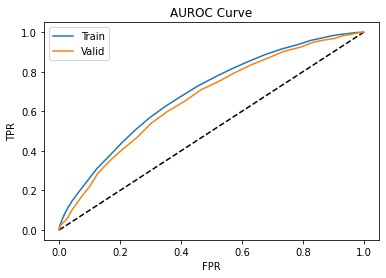

Model R2
Train Accuracy: 0.6685; Validation Accuracy: 0.6515
Train AUROC: 0.7080
Valid AUROC: 0.6639



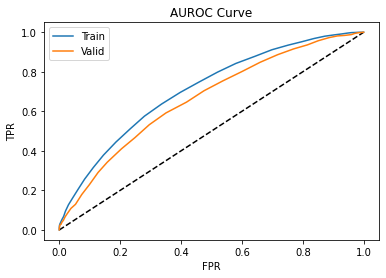

Model FA1
Train Accuracy: 0.6463; Validation Accuracy: 0.6399
Train AUROC: 0.6643
Valid AUROC: 0.6376



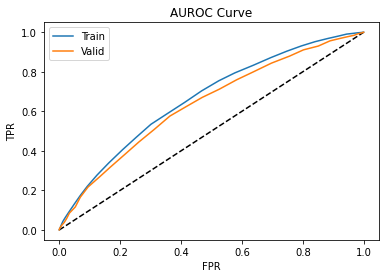

Model FA2
Train Accuracy: 0.6466; Validation Accuracy: 0.6338
Train AUROC: 0.6660
Valid AUROC: 0.6282



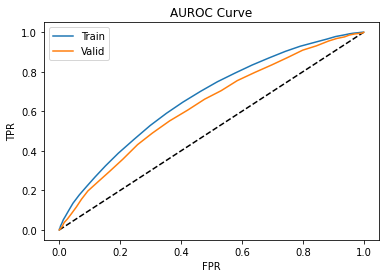

Model PCA1
Train Accuracy: 0.6455; Validation Accuracy: 0.6389
Train AUROC: 0.6626
Valid AUROC: 0.6361



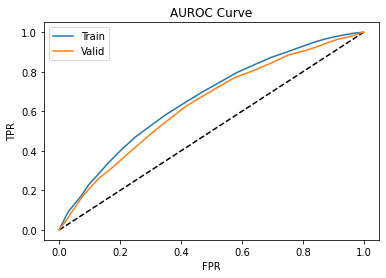

Model AE1
Train Accuracy: 0.6475; Validation Accuracy: 0.6387
Train AUROC: 0.6621
Valid AUROC: 0.6348



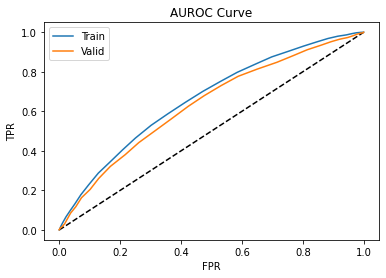

Model AE2
Train Accuracy: 0.6485; Validation Accuracy: 0.6326
Train AUROC: 0.6651
Valid AUROC: 0.6308



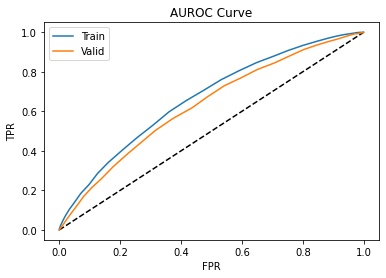

In [29]:
if not os.path.exists("../fig/prediction/KNN/"):
    os.makedirs("../fig/prediction/KNN/")
    
acr_knn = []
for i in range(len(train_list)):
    raw_train = train_list[i]
    raw_valid = valid_list[i]
    name = model_names[i]
    print(f"Model {name}")
    title = f"../fig/prediction/KNN/{name}.png"
    acr_train, acr_valid = KNN(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
    acr_knn.append((acr_train, acr_valid))

### MLP

In [30]:
from sklearn.neural_network import MLPClassifier

In [38]:
def MLP(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = MLPClassifier(hidden_layer_sizes=(20, 20, 10), max_iter=50, random_state=seed)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

Model R1
Train Accuracy: 0.6582; Validation Accuracy: 0.6446
Train AUROC: 0.6951
Valid AUROC: 0.6619



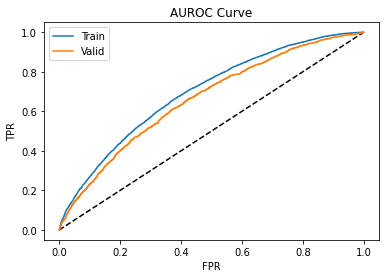

Model R2
Train Accuracy: 0.6964; Validation Accuracy: 0.6517
Train AUROC: 0.7513
Valid AUROC: 0.6659



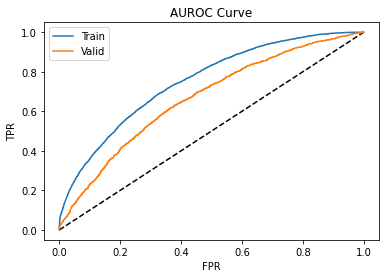

Model FA1
Train Accuracy: 0.6401; Validation Accuracy: 0.6476
Train AUROC: 0.6559
Valid AUROC: 0.6506



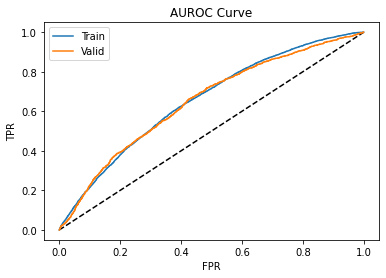

Model FA2
Train Accuracy: 0.6401; Validation Accuracy: 0.6377
Train AUROC: 0.6558
Valid AUROC: 0.6424



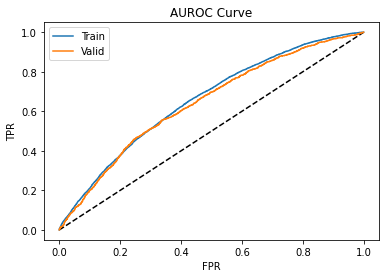

Model PCA1
Train Accuracy: 0.6374; Validation Accuracy: 0.6432
Train AUROC: 0.6560
Valid AUROC: 0.6512



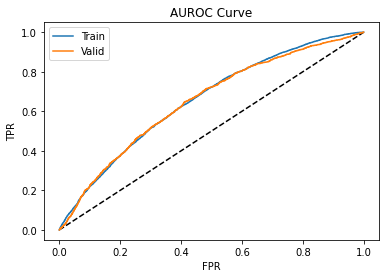

Model AE1
Train Accuracy: 0.6392; Validation Accuracy: 0.6409
Train AUROC: 0.6521
Valid AUROC: 0.6479



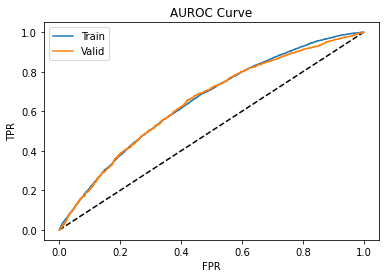

Model AE2
Train Accuracy: 0.6414; Validation Accuracy: 0.6336
Train AUROC: 0.6637
Valid AUROC: 0.6456



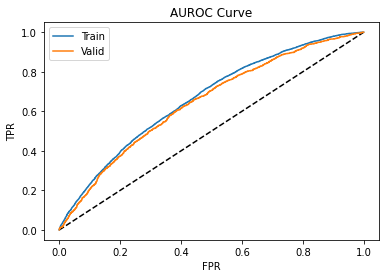

In [39]:
if not os.path.exists("../fig/prediction/MLP/"):
    os.makedirs("../fig/prediction/MLP/")
    
acr_mlp = []
for i in range(len(train_list)):
    raw_train = train_list[i]
    raw_valid = valid_list[i]
    name = model_names[i]
    print(f"Model {name}")
    title = f"../fig/prediction/MLP/{name}.png"
    acr_train, acr_valid = MLP(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
    acr_mlp.append((acr_train, acr_valid))

### SVM (abandon)

In [33]:
from sklearn import svm

In [34]:
def SVM(train, valid, test, train_y, valid_y, plot_auc=True, save_path=""):
    reg = svm.SVC(kernel='linear', C=1, probability=True)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=plot_auc, return_acu=True, save_path=save_path)

In [35]:
# if not os.path.exists("../fig/prediction/SVM/"):
#     os.makedirs("../fig/prediction/SVM/")
    
# acr_svm = []
# for i in range(len(train_list)):
#     raw_train = train_list[i]
#     raw_valid = valid_list[i]
#     name = model_names[i]
#     print(f"Model {name}")
#     title = f"../fig/prediction/SVM/{name}.png"
#     acr_train, acr_valid = SVM(train=raw_train, valid=raw_valid, test=None, train_y=train_label, valid_y=valid_label, plot_auc=True, save_path=title)
#     acr_svm.append((acr_train, acr_valid))

## Results Summarization

In [40]:
acrs = [acr_lr, acr_rf, acr_gb, acr_knn, acr_mlp]
acrs = [[f'{x[0]:.4f}/{x[1]:.4f}' for x in row] for row in acrs]
data = [[t[i] for t in acrs] for i in range(len(acrs[0]))]
results = pd.DataFrame(
    data, 
    columns=['LR', 'RF', 'GB', 'KNN', 'MLP'], 
    index=['R1', 'R2', 'FA1', 'FA2', 'PCA1', 'AE1', 'AE2']
)

In [41]:
writer = pd.ExcelWriter('../table/pred.xlsx', engine='xlsxwriter')
results.to_excel(writer, sheet_name='pred')
writer.close()